# FitzHugh-Nagumo: Nonlinear Dynamical System Analysis

Charles Xu @ Caltech

## System setup

The [FitzHugh-Nagumo Model](http://www.scholarpedia.org/article/FitzHugh-Nagumo_model) is a two-dimensional simplification of the Hodgkin-Huxley Model of spike generation in squid giant axons. It is given by two differential equations:
$$\begin{cases}
\dot{v} = v-\frac{v^3}{3}-w+I\\
\dot{w} = \epsilon(v+a-bw)
\end{cases}$$
Where:
- $v$ is the membrane potential
- $w$ is the recovery variable
- $I$ is the stimulus current
- $a$, $b$, and $\epsilon$ are parameters that dictate the system's behavior

To simplify the analysis, I will specify the constant values of the parameters $a$, $b$, and $\epsilon$ empirically determined from squid giant axons. The empirical system is given by:
$$\begin{cases}
\dot{v} = v-\frac{v^3}{3}-w+I\\
\dot{w} = 0.08(v+0.7-0.8w)
\end{cases}$$

In [528]:
## Set up the system of differential equations for the FitzHugh-Nagumo model
import sympy as sp

# Define the variables
v, w = sp.symbols('v w')

# Define the parameters
a = 0.7
b = 0.8
epsilon = 0.08
I_stim = 0

# Define the system of differential equations
dv_dt = v - (v**3)/3 - w + I_stim
dw_dt = epsilon * (v + a - b*w)
f = sp.Matrix([dv_dt, dw_dt])

# Print the equations
print("dv/dt =", dv_dt)
print("dw/dt =", dw_dt)


dv/dt = -v**3/3 + v - w
dw/dt = 0.08*v - 0.064*w + 0.056


## Lipschitz continuity of the system

Define a state vector $x\in\mathbb{R}^2$:
$$x \triangleq \begin{bmatrix} x_1 \\ x_2 \end{bmatrix} = \begin{bmatrix} v \\ w \end{bmatrix}$$
The dynamics can be written in $\dot{x} = f(x)$:
$$\dot{x} = f(x) = \begin{bmatrix} v-\frac{v^3}{3}-w+I \\ 0.08(v+0.7-0.8w) \end{bmatrix}$$

$f(x)$ is continuously differentiable with respect to both $v$ and $w$
Taking the Jacobian gives:
$$Df(x) = \begin{bmatrix} 1-v^2 & -1 \\ 0.08 & -0.064 \end{bmatrix}$$
The partial derivative $\frac{\delta f}{\delta v} = 1-v^2$ grows unboundedly with $v$, so we can conclude that the system $\dot{x}=f(x)$ is not globally Lipschitz continuous. However, because $f(x)$ is continuously differentiable, a local Lipschitz constant $L_0$ can be found by:
$$L_0 = \max_{x\in B_\epsilon(x_0)} \|Df(x)\|$$
indicating that at some point $x_0\in\mathbb{R}^2$, there exists such $L_0$ and some arbitrarily small $\epsilon\in\mathbb{R}_{>0}$ such that $x\in B_\epsilon(x_0)$ implies $\|Df(x)\|\le L_0$.

In [529]:
## Compute the local Lipschitz constant
from scipy.optimize import minimize

# Compute the Jacobian
Df = f.jacobian([v, w])

# Store the eigenvalues as functions of v and w
eig_Df = Df.eigenvals()
eig_funcs = [sp.lambdify([v, w], abs(eig)) for eig in eig_Df.keys()] 

# Define the objective function
def objective(x):
    v, w = x
    return -max([eig_func(v, w) for eig_func in eig_funcs])

# Initial guess for v and w
x0 = [0.0, 0.0]

# Solve the optimization problem
res = minimize(objective, x0, method='SLSQP', bounds=[(-2, 2), (-2, 2)])
L0 = -res.fun
print("L0 =", L0)

L0 = 0.9185818460612902


### Local Lipschitz constant

For a bounded region $v:(-2, 2), w:(-2, 2)$ around $x_0 = [0, 0]$, the local Lipschitz constant is $L_0 = 0.92$

## Solutions to the system

For nonlinear systems, solutions may not be unique or even exist for all time. Therefore, I would like to demonstrate the existence and uniqueness of solutions for this system by the Picard's method of approximation: $$z_{n+1} = P(z_n),\quad z_0 = x_0$$
where the Picard operator defined on continuous functions $C(I,E)$ is given by: $$\begin{align*}P: C(I,E) &\to C(I,E)\\ \phi(t) &\mapsto P(\phi)(t) = x_0 + \int_{t_0}^t f(\phi(s))ds \end{align*}$$

The sequence of Picard operators is a Cauchy sequence which converges to a fixed point $\lim_{n\to\infty}z_n = z^*$, which exists and is the unique solution of the initial value problem (IVP): $z^* = x(t)$. This can be proven by showing that $P: C(I,E) \to C(I,E)$ is a contraction mapping using the Contraction Mapping Principle

### Set initial conditions

In [530]:
## Set the initial conditions
import numpy as np

# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the initial condition
x0 = [0.0, 0.0]

### Solve using Picard Iteration

In [531]:
## Solve using Picard Iteration
from scipy.integrate import cumtrapz

# Define the system of equations
def f(x):
    v, w = x
    return [v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)]

# Initialize the solution
xt = np.tile(x0, (n, 1)).T

# Define tolerance
delta = np.inf
tol = 1e0

# Compute the solution
while delta > tol:
    xt_next = np.tile(x0, (n, 1)).T + cumtrapz(f(xt), t, initial=0, axis=1)
    delta = np.linalg.norm(xt_next - xt)
    print("delta =", delta)
    xt = xt_next
xt_picard = xt

delta = 1.6206578869496147
delta = 3.1606011270734604
delta = 3.9918878191853495
delta = 2.187513769825797
delta = 1.2363007631160456
delta = 0.482510819279465


**Theorem**

*Consider a locally Lipschitz continuous function: $f: E\to\mathbb{R}^n$ defined on the open and connected set $E \subseteq \mathbb{R}^n$. For any $x_0\in E$, there exists $a\in\mathbb{R}_{>0}$ for which the IVP: $$\dot{x} = f(x),\quad x(t_0) = x_0$$ has a unique solution, $x(t)$, on the interval $I = (t_0-a, t_0+a)$*

Therefore, demonstrating that the system is locally Lipschitz implies that for any IVP, we are guaranteed a unique solution on an open interval.

### Solve using ODE solver

In [532]:
## Solve using ODE solver
from scipy.integrate import solve_ivp

# Define the system of equations
def f(t, x):
    v, w = x
    return [v - (v**3)/3 - w + I, epsilon * (v + a - b*w)]

# Compute the solution
sol = solve_ivp(f, [t0, t_final], x0, t_eval=t, method='RK45')
xt_ode45 = sol.y

### Compare the solutions

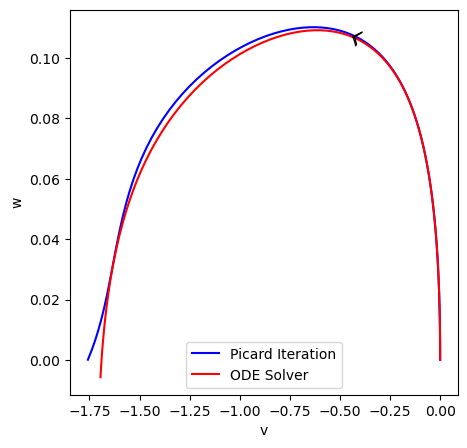

In [533]:
## Compare the solutions of the two methods
import matplotlib.pyplot as plt

# Plot the solutions
plt.figure(figsize=(5, 5))
plt.plot(xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
plt.plot(xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')
middle_index = len(xt_picard[0]) // 2

# Add arrows to indicate direction
plt.annotate('', xy=(xt_picard[0][middle_index], xt_picard[1][middle_index]), xytext=(xt_picard[0][middle_index-1], xt_picard[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor='blue'))
plt.annotate('', xy=(xt_ode45[0][middle_index], xt_ode45[1][middle_index]), xytext=(xt_ode45[0][middle_index-1], xt_ode45[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor='red'))
plt.xlabel('v')
plt.ylabel('w')
plt.legend()
plt.show()

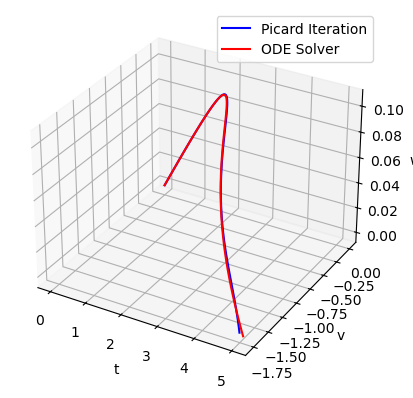

In [534]:
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure
fig = plt.figure()

# Create a 3D axis
ax = fig.add_subplot(111, projection='3d')

# Plot the solutions
ax.plot(t, xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
ax.plot(t, xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')

ax.set_xlabel('t')
ax.set_ylabel('v')
ax.set_zlabel('w')
ax.legend()

plt.show()

In [535]:
from ipywidgets import interact

def plot_func(angle1=30, angle2=30):
    # Create a new figure
    fig = plt.figure()

    # Create a 3D axis
    ax = fig.add_subplot(111, projection='3d')

    # Plot the solutions
    ax.plot(t, xt_picard[0], xt_picard[1], color='blue', label='Picard Iteration')
    ax.plot(t, xt_ode45[0], xt_ode45[1], color='red', label='ODE Solver')

    ax.set_xlabel('t')
    ax.set_ylabel('v')
    ax.set_zlabel('w')
    ax.legend()

    # Set the viewing angle
    ax.view_init(angle1, angle2)

    plt.show()

interact(plot_func, angle1=(0,360), angle2=(0,360))

interactive(children=(IntSlider(value=30, description='angle1', max=360), IntSlider(value=30, description='ang…

<function __main__.plot_func(angle1=30, angle2=30)>

## Continuity of solutions
### Continuous dependence on initial conditions

Continuity for initial conditions implies that for small changes in final position: $\|z(t)-x(t)\| < \epsilon, \space\forall\epsilon > 0$, one could find a small enough difference in initial conditions to satisfy the condition: $\exists\delta>0$ s.t. $\|z_0-x_0\| < \delta$

We can demonstrate the continuous dependence of this system on initial conditions by slightly purturbing the initial conditions and visualizing it on a bounded interval

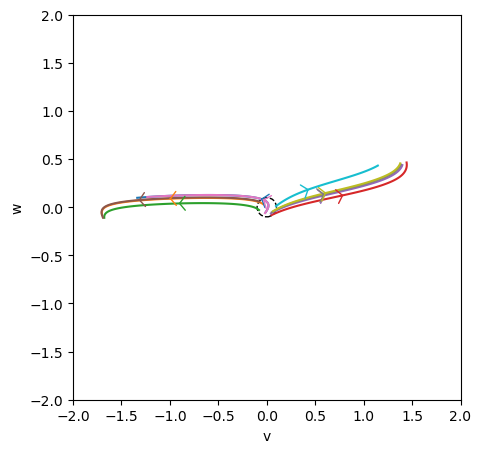

In [536]:
## Solve the system of equations for the purturbed initial conditions
import matplotlib.patches as patches
import matplotlib.colors as mcolors

# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the system of equations
def f(t, x):
    v, w = x
    return [v - (v**3)/3 - w + I, epsilon * (v + a - b*w)]

# Generate the purturbed initial conditions
num_conditions = 10
radius = 0.1
angles = 2 * np.pi * np.random.rand(num_conditions)
radii = radius * np.sqrt(np.random.rand(num_conditions))
z0s = np.array([radii * np.cos(angles), radii * np.sin(angles)]).T

# Create a new figure
fig, ax = plt.subplots(figsize=(5, 5))

# Loop over the initial conditions
for z0 in z0s:
    # Compute the solution
    sol = solve_ivp(f, [t0, t_final], z0, t_eval=t, method='RK45')
    zt = sol.y

    # Plot the solution
    line, = ax.plot(zt[0], zt[1])

    # Add arrows to indicate direction
    middle_index = len(zt[0]) // 2
    arrowcolor = np.array(mcolors.to_rgba(line.get_color()))
    ax.annotate('', xy=(zt[0][middle_index], zt[1][middle_index]), xytext=(zt[0][middle_index-1], zt[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor=arrowcolor, edgecolor=arrowcolor))

# Draw the ball
circle = patches.Circle((0, 0), radius, fill=False, linestyle='dashed', edgecolor='black')
ax.add_patch(circle)
ax.set_xlabel('v')
ax.set_ylabel('w')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.show()

#### Boundary value $\mu$

We can compute a boundary value $\mu$ for the solution difference between the original and perturbed system, $g$, satisfying the following inequality: $$\|x(t)-z(t)\| \le \|x_0-z_0\|e^{L(t-t_0)} + \mu(t-t_0)e^{L(t-t_0)}$$
Thus, $\mu$ is given by: $$\mu = \frac{\|x(t)-z(t)\| - \|x_0-z_0\|e^{L(t-t_0)}}{(t-t_0)e^{L(t-t_0)}}$$

In the following demonstration, let's perturb the system by setting initial condition from $x_0$ to $z_0 = [0.1, 0.0]$

In [537]:
## Compute the bound on the distance between the solutions, mu
# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the initial conditions
x0 = np.array([0.0, 0.0])
z0 = np.array([0.1, 0.0])

# Initialize the solutions
xt = np.tile(x0, (n, 1)).T
zt = np.tile(z0, (n, 1)).T

# Define the system of equations
def f(t, x):
    v, w = x
    return [v - (v**3)/3 - w + I, epsilon * (v + a - b*w)]

# Compute the solutions
x0_sol = solve_ivp(f, [t0, t_final], x0, t_eval=t, method='RK45')
xt = x0_sol.y
z0_sol = solve_ivp(f, [t0, t_final], z0, t_eval=t, method='RK45')
zt = z0_sol.y

# Compute mu
mu = (np.linalg.norm(xt - zt) - np.linalg.norm(x0 - z0) * np.exp(L0 * (t_final - t0))) / (t_final - t0) * np.exp(L0 * (t_final - t0))
print("mu =", mu)

mu = 135.36024740583753


In [538]:
## Compute the left- and right-hand sides of the inequality
lhs = np.linalg.norm(xt - zt, axis=0)
rhs = np.linalg.norm(x0 - z0) * np.exp(L0 * (t - t0)) + mu * (t - t0) * np.exp(L0 * (t - t0))

if np.all(lhs <= rhs):
    print("The inequality is satisfied at all times!")
else:
    print("The inequality is NOT satisfied at all times!")

The inequality is satisfied at all times!


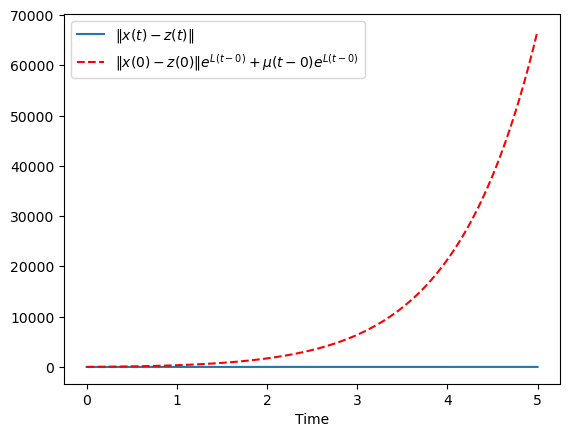

In [539]:
## Plot the time-varying upper bound on the distance between the solutions
fig, ax = plt.subplots()
ax.plot(t, lhs, label='$\|x(t) - z(t)\|$')
ax.plot(t, rhs, 'r--', label='$\|x(0) - z(0)\| e^{L(t - 0)} + \mu (t - 0) e^{L(t - 0)}$')
ax.set_xlabel('Time')
ax.legend()
plt.show()

### Continuous dependence on parameters

Continuity for parameters can be similarly demonstrated by purturbing the system's parameters slightly and examining the resulting solutions to IVPs with respect to the same initial conditions

For the FitzHugh-Nagumo system, we can perturb one of the parameters, $I$, to simulate an external current injection into the neuron. Let's set $I = 10$ to simulate a current injection at 10 mV

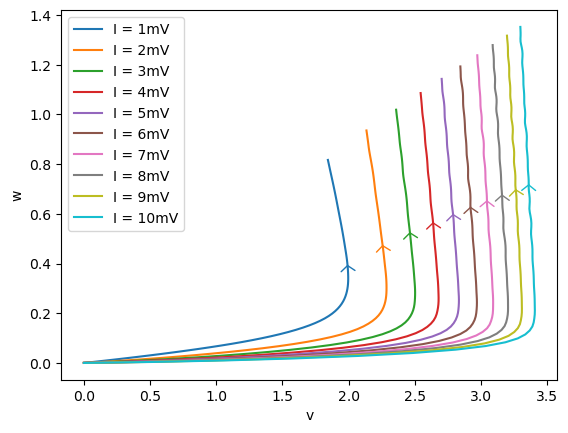

In [540]:
## Solve the system of equations for the purturbed parameters
# Define the time interval
t0, t_final = 0.0, 5.0
n = 100
t = np.linspace(t0, t_final, n)

# Define the system of equations
def f(t, x, I_stim):
    v, w = x
    return [v - (v**3)/3 - w + I_stim, epsilon * (v + a - b*w)]

# Define the initial condition
x0 = [0, 0]

# Create a new figure
fig, ax = plt.subplots()

# Solve the system for different values of I
for lambda_I in range(1, 11):
    # Solve the system
    sol = solve_ivp(f, [t0, t_final], x0, t_eval=t, args=(lambda_I,), method='RK45')
    xt = sol.y

    # Plot the solution
    line, = ax.plot(xt[0], xt[1], label=f'I = {lambda_I}mV')

    # Add arrows to indicate direction
    middle_index = len(xt[0]) // 2
    arrowcolor = np.array(mcolors.to_rgba(line.get_color()))
    ax.annotate('', xy=(xt[0][middle_index], xt[1][middle_index]), xytext=(xt[0][middle_index-1], xt[1][middle_index-1]), arrowprops=dict(arrowstyle='->,head_width=0.5', facecolor=arrowcolor, edgecolor=arrowcolor))

ax.set_xlabel('v')
ax.set_ylabel('w')
ax.legend()
plt.show()

## Linearization

The linearization of a nonlinear system is given by: $$\dot{x} = f(x) \quad\mapsto\quad \dot{x} = Df(x^*)x$$ around an equilibrium point $x^*$ satisfying $f(x^*) = 0$. Thus, linearizing the system requires first finding an equilibrium

### Equilibrium

In [545]:
## Solve for the equilibrium points
equilibria = sp.solve([dv_dt, dw_dt], (v, w))

# Print the equilibrium points
for equilibrium in equilibria:
    print(f'An equilibrium point is at v = {equilibrium[0]}, w = {equilibrium[1]}')

An equilibrium point is at v = -1.19940803524404, w = -0.624260044055044
An equilibrium point is at v = 0.599704017622018 - 1.35238113202454*I, w = 1.62463002202752 - 1.69047641503067*I
An equilibrium point is at v = 0.599704017622018 + 1.35238113202454*I, w = 1.62463002202752 + 1.69047641503067*I


In [546]:
# Select the real equilibrium point
x_star = equilibria[0]
x_star

(-1.19940803524404, -0.624260044055044)

### Linear system

The linearized linear system $\dot{x} = Ax$ is given by evaluating the Jacobian at the equilibrium $A\triangleq Df(x^*)$

In [547]:
# Evaluate the Jacobian at the equilibrium
A = Df.subs({v: x_star[0], w: x_star[1]})
A

Matrix([
[-0.438579635007956,     -1],
[              0.08, -0.064]])